# Supercrunchers

## Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import itertools

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, KFold, cross_validate, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, get_scorer_names, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils import resample
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from category_encoders.target_encoder import TargetEncoder

import matplotlib.pyplot as plt


In [3]:
pd.set_option("display.precision", 2)

## Data Loading and Inspection

In [4]:
# Get the dataset
file_path = 'data/soccer_data.dta'
csv_path = 'data/soccer_data.csv'
df_all = pd.read_stata(file_path)
df_all.to_csv(csv_path)
df_all['date'] = pd.to_datetime(df_all['date'], format='%d/%m/%Y')

In [5]:
df_all.head()

,v1,competition,competition_id,date,match,match_id,team,team_id,player,player_id,...,position,position_role,rat,kicker,bild,skysports,goalkeeper,defender,midfielder,forward
0,0,Euro 2016,102,2016-06-10,"France - Romania, 2 - 1",1694390,Romania,11944,Dragos Grigore,84536,...,Defender,DC,Kicker,1,0,0,0,1,0,0
1,1,Euro 2016,102,2016-06-10,"France - Romania, 2 - 1",1694390,Romania,11944,Dragos Grigore,84536,...,Defender,DC,WhoScored,0,0,0,0,1,0,0
2,2,Euro 2016,102,2016-06-10,"France - Romania, 2 - 1",1694390,Romania,11944,Dragos Grigore,84536,...,Defender,DC,SofaScore,0,0,0,0,1,0,0
3,4,Euro 2016,102,2016-06-10,"France - Romania, 2 - 1",1694390,Romania,11944,Mihai Pintilii,83824,...,Midfielder,DMC,Kicker,1,0,0,0,0,1,0
4,5,Euro 2016,102,2016-06-10,"France - Romania, 2 - 1",1694390,Romania,11944,Mihai Pintilii,83824,...,Midfielder,DMC,WhoScored,0,0,0,0,0,1,0


In [6]:
# df_all[['player_id', 'match_id']].drop_duplicates()
df_all[['player']].value_counts()
# df_all.loc[(df_all['player_id'] == 84536) & (df_all['rat'] == 'WhoScored'), ['original_rating', 'date']]
# df_all[['rat', 'is_human', 'original_rating']].describe()
# df_all.groupby('rat')['original_rating'].describe()
# df_all['position'].unique()
df_all['minutesplayed'].describe()

count    43689.00
mean        85.76
std         10.62
min         45.00
25%         90.00
50%         90.00
75%         90.00
max        120.00
Name: minutesplayed, dtype: float64

## Preprocessing

In [7]:
def filter_columns(df, filters):
    for col, val in filters.items():
        df = df.loc[df[col] == val]

    return df

def clean_columns(df):
    # drop some columns
    useless_columns = ['v1', 'rating', 'team_rating', 'kicker', 'bild', 'skysports', 'goalkeeper', 'defender', 'midfielder', 'forward']
    redundant_columns = ['competition_id', 'match_id', 'team_id', 'player', 'win', 'lost', 'position']
    
    nonfeature_columns = ['player_id', 'team_pos_rating', 'team_rating_original', 'past_performances', 
    'opp_rating', 'opp_rating_original', 'opp_gk_rating', 'opp_bestdf_rating', 'opp_bestmf_rating', 'opp_bestfw_rating', 
    'rat', 'is_human']

    different_encoded_columns = ['match', 'date']
    df_clean = df.drop(columns=useless_columns + redundant_columns + nonfeature_columns + different_encoded_columns)

    def get_match_result(match:str, is_home_team:bool):
        score = match[-5:]
        score = score.split(" - ")
        result = 0
        if score[0] == score[1]:
            result = 0

        if score[0] > score[1]:
            result = 1

        if score[0] < score[1]:
            result = -1

        if not is_home_team:
            result = -1 * result

        return result

    # add columns
    df_clean['result'] = df[['match', 'is_home_team']].apply(lambda x: get_match_result(x['match'], x['is_home_team']), axis=1)

    # date
    date = pd.to_datetime(df['date'], format="%d/%m/%Y")
    df_clean['weekday'] = date.dt.weekday
    df_clean['month'] = date.dt.month
    return df_clean


def split_dataset(df):
    # Split the df into X and y
    X = df.drop(columns=['original_rating'])
    y = df['original_rating']

    return X, y

In [45]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def create_pipeline(df, model):
    # define feature types
    numeric_features = set(df.select_dtypes(
        exclude=["category", "object"]).columns)
    categorical_features = set(df.select_dtypes(
        include=['category', "object"]).columns)
    cyclic_features = {'weekday', 'month'}
    team_feature = {'team'}
    
    numeric_features -= cyclic_features
    categorical_features -= cyclic_features
    categorical_features -= team_feature

    numeric_features = list(numeric_features)
    categorical_features = list(categorical_features)
    cyclic_features = list(cyclic_features)
    team_feature = list(team_feature)

    # print(numeric_features)
    # print(categorical_features)
    # print(cyclic_features)

    # transformer for numeric features
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(missing_values=np.nan, strategy='median', add_indicator=True)),
            # ("scaler", RobustScaler()),
            # ("scaler", StandardScaler()),
        ]
    )

    # transformer for categorical features
    categorical_transformer = Pipeline(
        steps=[
            ("ohe", OneHotEncoder(handle_unknown='ignore', sparse=False)),
        ]
    )

    # preprocessing transformer, applies different transformations on different features
    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_features),
            ("categorical", categorical_transformer, categorical_features),
            ("team", TargetEncoder(handle_missing='value', handle_unknown='value'), team_feature),
            ("month_sin", sin_transformer(12), ["month"]),
            ("month_cos", cos_transformer(12), ["month"]),
            ("weekday_sin", sin_transformer(7), ["weekday"]),
            ("weekday_cos", cos_transformer(7), ["weekday"]),
        ]
    )

    # final pipeline preprocessing + classifier
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("scaler", StandardScaler()),
            # ('pca', PCA(n_components='mle')),
            ("model", model),
        ]
    )

    return pipe


In [55]:
# To see the transformed dataset that the model will actually run on
df_f = filter_columns(df_all, {'rat': 'Kicker', 'position': 'Forward'})
df_temp = clean_columns(df_f)
X_temp, y_temp = split_dataset(df_temp)
preprocessor = create_pipeline(X_temp, None)
preprocessor.steps.pop(-1)
temp = preprocessor.fit_transform(X_temp, y_temp)
temp = pd.DataFrame(temp)
temp.describe()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
count,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,...,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03,1.40e+03
mean,-3.29e-17,-5.06e-17,6.28e-16,5.82e-17,-2.53e-17,1.82e-16,7.09e-17,1.52e-17,-1.22e-16,-2.53e-18,...,-1.01e-16,1.62e-16,-1.27e-17,-4.30e-17,2.03e-17,-1.33e-14,1.62e-16,8.10e-17,-7.31e-15,1.33e-15
std,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,...,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
min,-7.05e-01,-4.58e-01,-1.29e-01,-1.68e+00,-3.78e-02,-2.40e+00,-1.72e+00,-1.53e+00,-2.14e+00,-7.32e-01,...,-3.56e-01,-3.87e-01,-1.89e+00,-3.52e-01,-3.50e-01,-2.10e+00,-1.52e+00,-1.28e+00,-6.35e-01,-1.64e+00
25%,-7.05e-01,-4.58e-01,-1.29e-01,-5.38e-01,-3.78e-02,-7.69e-01,-6.84e-01,-6.72e-01,-7.26e-01,-7.32e-01,...,-3.56e-01,-3.87e-01,5.30e-01,-3.52e-01,-3.50e-01,-5.52e-01,-7.84e-01,-1.09e+00,-6.35e-01,-3.68e-01
50%,-7.05e-01,-4.58e-01,-1.29e-01,-1.58e-01,-3.78e-02,-7.16e-02,-8.50e-02,-2.16e-01,-1.46e-01,3.61e-02,...,-3.56e-01,-3.87e-01,5.30e-01,-3.52e-01,-3.50e-01,-8.15e-02,-4.95e-02,9.66e-02,-6.35e-01,-3.68e-01
75%,5.29e-01,-4.58e-01,-1.29e-01,6.00e-01,-3.78e-02,6.26e-01,5.73e-01,4.68e-01,6.12e-01,3.61e-02,...,-3.56e-01,-3.87e-01,5.30e-01,-3.52e-01,-3.50e-01,5.91e-01,1.22e+00,7.83e-01,2.66e-01,1.21e+00
max,9.17e+00,8.52e+00,7.75e+00,4.77e+00,2.65e+01,4.11e+00,5.27e+00,5.71e+00,3.88e+00,6.18e+00,...,2.81e+00,2.58e+00,5.30e-01,2.84e+00,2.86e+00,2.92e+00,1.42e+00,1.47e+00,2.61e+00,1.92e+00


## Group Comparison Testing

In [10]:
def test_group_effects(df_base: pd.DataFrame):
    # clean the df for classification task
    df = clean_columns(df_base)
    df: pd.DataFrame = df.drop(columns=['original_rating'])
    df = df.drop_duplicates()
    X = df

    # get the target value and encode it
    y = df_base['player'].iloc[df.index]
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    models = [RandomForestClassifier(min_samples_leaf=10), DummyClassifier(strategy='stratified', random_state=42)]
    for model in models:
        pipe = create_pipeline(X, model)

        # do cross validation
        s = cross_validate(
            pipe,
            X,
            y,
            cv=StratifiedKFold(10),
            scoring=['accuracy', 'f1_micro', 'f1_macro'],
            n_jobs=-1,
        )
        # evaluate

        acc_scores = s['test_accuracy']
        f1_micro_scores = s['test_f1_micro']
        f1_macro_scores = s['test_f1_macro']

        acc = np.percentile(acc_scores, 100)
        f1_micro = np.percentile(f1_micro_scores, 100)
        f1_macro = np.percentile(f1_macro_scores, 100)

        print({'model': model.__class__.__name__,'acc': acc, 'f1_micro':f1_micro, 'f1_macro': f1_macro})



test_group_effects(df_all)

/Users/ahmetayrnc/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


{'model': 'RandomForestClassifier', 'acc': 0.3333333333333333, 'f1_micro': 0.3333333333333333, 'f1_macro': 0.19066976446431566}


/Users/ahmetayrnc/Library/Python/3.8/lib/python/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


{'model': 'DummyClassifier', 'acc': 0.002335084646818447, 'f1_micro': 0.002335084646818447, 'f1_macro': 0.0013175230566534913}


## Bootstrapping

In [11]:
class Bootstrap:
    def __init__(self, nr):
        self.nr = nr
    
    def split(self, X, y, groups=None):
        idx = range(len(X))
        splits = []
        for i in range(self.nr):
            train = resample(idx, replace=True, n_samples=len(X), random_state=i)
            test = list(set(idx) - set(train))
            splits.append((train, test))
        return splits


class GroupedBootstrap:
    def __init__(self, nr):
        self.nr = nr
    
    def split(self, X, y, groups):
        idx = X.index
        splits = []
        for i in range(self.nr):
            # sample the players
            train_players =  resample(groups.unique(), replace=True, random_state=i)

            # collect all the records for the players in our player samples
            train = []
            for train_player in train_players:
                train_subset = groups.loc[groups == train_player]
                train += train_subset.index.tolist()

            # remove the sampled records from all records to get the out of bag records
            test = list(set(idx) - set(train))

            # append the split to the splits
            splits.append((train, test))

        return splits

def test_grouped_bs(df):
    # create datasets
    filter_dict = {'rat':'Kicker'}
    df = filter_columns(df, filter_dict)
    groups = df['player']
    df = clean_columns(df)
    X, y = split_dataset(df)

    gbs = GroupedBootstrap(10)
    splits = gbs.split(X, y, groups)
    print(len(splits))
    for split in splits:
        print(len(split[0]), len(split[1]))


test_grouped_bs(df_all)

10
9175 3365
8306 3241
8585 3279
9303 3170
8427 3416
9314 3191
8684 3047
8737 3317
9121 3244
8798 3108


## Hyper-parameter Optimizations

## Evaluation

In [12]:
def train_and_test(df):
    groups = df['player']
    # create datasets
    df = clean_columns(df)
    X, y = split_dataset(df)

    # create the pipeline
    model = Ridge()
    model = RandomForestRegressor(min_samples_leaf=20, n_jobs=-1, random_state=42, verbose=0)
    pipe = create_pipeline(X, model)

    # do cross validation
    s = cross_validate(
        pipe,
        X,
        y,
        cv=Bootstrap(100),
        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
        n_jobs=-1,
        groups=groups,
    )

    # evaluate
    r2_scores = s['test_r2']
    mae_scores = s['test_neg_mean_absolute_error'] * -1
    mse_scores = s['test_neg_mean_squared_error'] * -1

    r2 = np.percentile(r2_scores, 95)
    mae = np.percentile(mae_scores, 95)

    # sigma2
    mse = np.percentile(mse_scores, 95)
    sigma2 = mse * (X.shape[0] / (X.shape[0] - X.shape[1] + 1))
    
    return {'r2': r2, 'mae': mae, 'sigma^2': sigma2}


def evaluate(df):
    ratings = ['Kicker', 'WhoScored', 'SkySports', 'Bild', 'SofaScore', 'The Guardian']
    positions = ['Forward', "Midfielder", 'Defender', 'Goalkeeper']
    results = []

    for rat, pos in itertools.product(ratings, positions):
        filter_dict = {'rat':rat, 'position': pos}
        df_eval = filter_columns(df, filter_dict)
        result = train_and_test(df_eval)
        res = {**filter_dict, **result}
        results.append(res)
        print(res)

    return pd.DataFrame(results)

results_df = evaluate(df_all)
results_df


{'rat': 'Kicker', 'position': 'Forward', 'r2': 0.6697100857939267, 'mae': 0.5507918825630985, 'sigma^2': 0.5125837132833543}
{'rat': 'Kicker', 'position': 'Midfielder', 'r2': 0.47020167769197174, 'mae': 0.5583384765947709, 'sigma^2': 0.4956927656506568}
{'rat': 'Kicker', 'position': 'Defender', 'r2': 0.37933165604402147, 'mae': 0.553963619182116, 'sigma^2': 0.4934025138280255}
{'rat': 'Kicker', 'position': 'Goalkeeper', 'r2': 0.28591805514655805, 'mae': 0.539097364367981, 'sigma^2': 0.6223999949588163}
{'rat': 'WhoScored', 'position': 'Forward', 'r2': 0.7884474985206045, 'mae': 0.3340606980456977, 'sigma^2': 0.19674301647298023}
{'rat': 'WhoScored', 'position': 'Midfielder', 'r2': 0.6822099665553182, 'mae': 0.3231268648330119, 'sigma^2': 0.18021256916121384}


KeyboardInterrupt: 

## Feature Importances

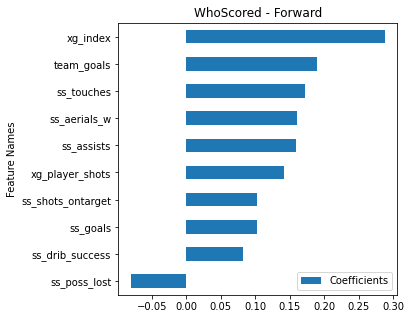

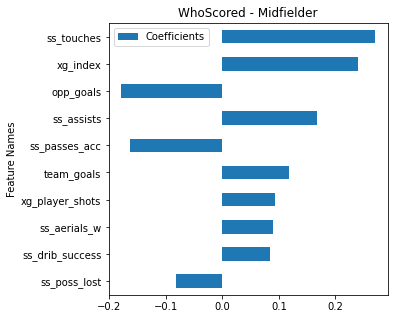

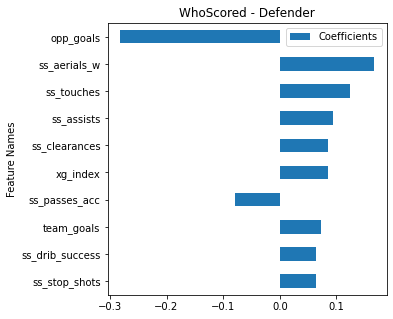

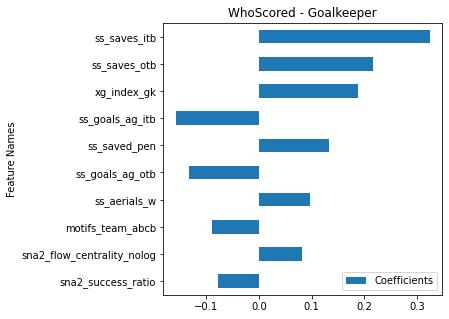

In [59]:
def plot_features(df, title, topk=10):
    # create datasets
    df = clean_columns(df)
    X, y = split_dataset(df)

    # create the pipeline
    model = Ridge()
    pipe = create_pipeline(X, model)
    pipe.fit(X, y)

    # Get the feature names
    num_names = pipe.named_steps['preprocessor'].named_transformers_['numeric'].named_steps['imputer'].feature_names_in_
    cat_names = pipe.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['ohe'].get_feature_names_out()
    coef_names = list(num_names) + list(cat_names) + ['team', 'month_sin', 'month_cos', 'month_sin', 'month_cos']
    
    # Get the coefficients
    coefs = pipe.named_steps['model'].coef_

    # Plot the coefficients
    coefs = pd.DataFrame(zip(coef_names, coefs), columns=['Feature Names', 'Coefficients'])
    coefs = coefs.sort_values(by='Coefficients', key=abs, ascending=True)
    coefs = coefs.iloc[-topk:]
    p = coefs.plot(x='Feature Names', y='Coefficients', kind='barh', figsize=(5,topk * 0.5), title=title)
    fig = p.get_figure()
    fig.savefig(f"feature-images/{title}.jpeg", transparent=False, bbox_inches='tight')
    plt.show()


def plot_features_all(df):
    ratings = ['WhoScored']
    # ratings = ['Kicker', 'WhoScored', 'SkySports', 'Bild', 'SofaScore', 'The Guardian']
    positions = ['Forward', "Midfielder", 'Defender', 'Goalkeeper']
    # positions = ['Goalkeeper']

    for rat, pos in itertools.product(ratings, positions):
        filter_dict = {'rat':rat, 'position': pos}
        df_eval = filter_columns(df, filter_dict)
        title = f'{rat} - {pos}'
        plot_features(df_eval, title, 10)
    plt.close()

plot_features_all(df_all)


In [ ]:
# r2: 0.522, mae: 0.521, sigma2: 0.437, error: 1.916
# r2: 0.766, mae: 0.280, sigma2: 0.132, error: 0.824
# r2: 0.450, mae: 0.602, sigma2: 0.588, error: 2.380